In [1]:
%matplotlib inline
import numpy as np
import torch
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorboardX, datetime
import pandas as pd
from scipy.special import gamma
from torch import nn
from scipy.stats import special_ortho_group
from collections import defaultdict
from collections import OrderedDict as odict
from copy import deepcopy

## Theory

Consider the $d$-dimensional space $\mathbb{R}^{d}$, and the following charge:

$$\rho(x) = \delta^d(x).$$

For $d \neq 2$, the analytical solution to the system

$$\nabla \cdot \vec{E} = \rho$$

$$\nabla V = \vec{E}$$

can be defined as 

$$V_{\vec{x}} = \frac{\Gamma(d/2)}{2\cdot\pi^{d/2}\cdot (2-d)} \|\vec{x}\|^{2-d}, $$

$$\vec{E}_{\vec{x}} = \frac{\Gamma(d/2)}{2\cdot \pi^{d/2}\cdot \|\vec{x}\|^{d}} \vec{x}.$$

For $d=2$, $\vec{E}_{\vec{x}}$ is the same, but for $V_{\vec{x}}$ we have

$$V_{\vec{x}} = \frac{1}{2\pi} \ln(\|\vec{x}\|).$$

We want to solve this system using the divergence theorem:

$$\iint_{S_{d-1}(V)} \vec{E}\cdot \hat{n}\text{ d}S = \iiint_{V_d} \nabla.\vec{E}\text{ d}V.$$

Keep in mind that the $d-1$-dimensional surface of a $d$-dimensional shpere with radius $r$ is 
$$\iint_{S_{d-1}(V^{\text{d-Ball}}_{r})} 1\text{ d}S = \frac{2\cdot \pi^{d/2}}{\Gamma(d/2)}\cdot r^{d-1}.$$

In [2]:
device_name = 'cuda:0'
tch_device = torch.device(device_name)
tch_dtype = torch.double
torch.pi = torch.tensor(np.pi).to(device=tch_device, dtype=tch_dtype)

def isscalar(v):
    if torch.is_tensor(v):
        return v.numel() == 1
    else:
        return np.isscalar(v)

## Defining the Problem and the Analytical Solution

In [3]:
class DeltaProblem:
    def __init__(self, weights, locations):
        # weights          -> np.array -> shape=(n_bch, n_chrg)
        # locations.shape  -> np.array -> shape=(n_bch, n_chrg, d)
        self.weights = weights
        self.locations = locations
        self.n_bch, self.n_chrg = self.weights.shape
        self.d = self.locations.shape[-1]
        assert self.weights.shape   == (self.n_bch, self.n_chrg,)
        assert self.locations.shape == (self.n_bch, self.n_chrg, self.d)
        self.weights_tch = torch.from_numpy(self.weights).to(tch_device, tch_dtype)
        self.locations_tch = torch.from_numpy(self.locations).to(tch_device, tch_dtype)
    
    def integrate_volumes(self, volumes):
        # volumes -> dictionary
        assert volumes['type'] == 'balls'
        centers = volumes['centers']
        radii = volumes['radii']
        n_v = radii.shape[-1]
        n_bch, n_chrg, d = self.n_bch, self.n_chrg, self.d
        assert radii.shape == (n_bch, n_v,)
        assert centers.shape == (n_bch, n_v, d)
        lib = torch if torch.is_tensor(centers) else np 
        mu = self.locations_tch if torch.is_tensor(centers) else self.locations
        w = self.weights_tch if torch.is_tensor(centers) else self.weights
        
        c_diff_mu = centers.reshape(n_bch, n_v, 1, d) - mu.reshape(n_bch, 1, n_chrg, d)
        assert c_diff_mu.shape == (n_bch, n_v, n_chrg, d)
        distl2 = lib.sqrt(lib.square(c_diff_mu).sum(-1))
        assert distl2.shape == (n_bch, n_v, n_chrg)
        integ = ((distl2 < radii.reshape(n_bch, n_v, 1)) * w.reshape(n_bch, 1, n_chrg)).sum(-1)
        assert integ.shape == (n_bch, n_v)
        return integ
    
    def potential(self, x):
        lib = torch if torch.is_tensor(x) else np 
        w = self.weights_tch if torch.is_tensor(x) else self.weights
        mu = self.locations_tch if torch.is_tensor(x) else self.locations
        n_bch, n_chrg, d = self.n_bch, self.n_chrg, self.d
        n_x = x.shape[-2]
        assert x.shape == (n_bch, n_x, d)
        x_diff_mu = x.reshape(n_bch, n_x, 1, d) - mu.reshape(self.n_bch, 1, n_chrg, d)
        assert x_diff_mu.shape == (n_bch, n_x, n_chrg, d)
        x_dists = lib.sqrt(lib.square(x_diff_mu).sum(-1))
        assert x_dists.shape == (n_bch, n_x, n_chrg)
        if d != 2:
            poten1 = (x_dists**(2-d))
            assert poten1.shape == (n_bch, n_x, n_chrg)
            poten2 = (poten1 * w.reshape(n_bch, 1, n_chrg)).sum(-1)
            assert poten2.shape == (n_bch, n_x)
            cst = gamma(d/2) / (2*(lib.pi**(d/2)))
            cst = cst / (2-d)
            assert isscalar(cst)
            poten = cst * poten2
            assert poten.shape == (n_bch, n_x)
        else:
            poten1 = lib.log(x_dists)
            assert poten1.shape == (n_bch, n_x, n_chrg)
            poten2 = (poten1 * w.reshape(n_bch, 1, n_chrg)).sum(-1)
            assert poten2.shape == (n_bch, n_x)
            poten = poten2 / (2*lib.pi)
            assert poten.shape == (n_bch, n_x)
        return poten
    
    def field(self, x):
        lib = torch if torch.is_tensor(x) else np 
        w = self.weights_tch if torch.is_tensor(x) else self.weights
        mu = self.locations_tch if torch.is_tensor(x) else self.locations
        n_bch, n_chrg, d = self.n_bch, self.n_chrg, self.d
        n_x = x.shape[-2]
        assert x.shape == (n_bch, n_x, d)
        x_diff_mu = x.reshape(n_bch, n_x, 1, d) - mu.reshape(n_bch, 1, n_chrg, d)
        assert x_diff_mu.shape == (n_bch, n_x, n_chrg, d)
        x_dists = lib.sqrt(lib.square(x_diff_mu).sum(-1))
        assert x_dists.shape == (n_bch, n_x, n_chrg)
        poten1 = (x_dists**(-d))
        assert poten1.shape == (n_bch, n_x, n_chrg)
        poten2 = (poten1 * w.reshape(n_bch, 1, n_chrg)).sum(-1)
        assert poten2.shape == (n_bch, n_x)
        cst = gamma(d/2) / (2*(lib.pi**(d/2)))
        assert isscalar(cst)
        poten = cst * poten2
        assert poten.shape == (n_bch, n_x)
        field = poten.reshape(n_bch, n_x, 1) * x
        assert field.shape == (n_bch, n_x, d)
        return field

## Visualizing the True Potential and Fields

In [4]:
x1_1d = torch.linspace(-1.0, 1.0, 50, requires_grad=True, dtype=tch_dtype, device=tch_device)
x2_1d = torch.linspace(-1.0, 1.0, 50, requires_grad=True, dtype=tch_dtype, device=tch_device)
x1_msh, x2_msh = torch.meshgrid(x1_1d, x2_1d)
x1 = x1_msh.reshape(-1, 1)
x2 = x2_msh.reshape(-1, 1)
x1_1d_c = x1_1d.reshape(-1, 1)
x2_1d_c = x2_1d.reshape(-1, 1)
x1_msh_np = x1_msh.detach().cpu().numpy()
x2_msh_np = x2_msh.detach().cpu().numpy()
x = torch.cat([x1, x2], dim=1)
x_np = x.detach().cpu().numpy()
x_plt, x_plt_np = x, x_np
x1_plt_msh_np, x2_plt_msh_np = x1_msh_np, x2_msh_np

In [5]:
def do_plot(x1_msh_np, x2_msh_np, v_msh_np, e_msh_np=None, e_percentile_cap=None, 
            dpi=72, fig_ax=None):
    plt.ioff()
    if fig_ax is None:
        fig = plt.figure(dpi=dpi)
        ax = plt.gca()
    else:
        fig, ax = fig_ax
    im = ax.pcolormesh(x1_msh_np, x2_msh_np, v_msh_np, shading='auto', cmap='RdBu')
    fig.colorbar(im, ax=ax)
    if e_msh_np is not None:
        if e_percentile_cap is not None:
            e_size = np.sqrt((e_msh_np**2).sum(axis=-1))
            e_size_cap = np.percentile(a=e_size, q=e_percentile_cap, axis=None)
            cap_coef = np.ones_like(e_size)
            cap_coef[e_size > e_size_cap] = e_size_cap / e_size[e_size > e_size_cap]
            e_msh_capped = e_msh_np * cap_coef.reshape(*e_msh_np.shape[:-1], 1)
        else:
            e_msh_capped = e_msh_np
        
        ax.quiver(x1_msh_np, x2_msh_np, e_msh_capped[:, :, 0], e_msh_capped[:, :, 1])
    return fig, ax

In [6]:
prob2d_ex1 = DeltaProblem(weights=np.array([[1.0]]),
                         locations=np.array([[[ 0.0,  0.0]]]))

prob2d_ex1 = DeltaProblem(weights=np.array([[1.0, 1.0, 1.0]]),
                         locations=np.array([[[ 0.0,  0.0],
                                              [-0.5, -0.5],
                                              [ 0.5,  0.5]]]))

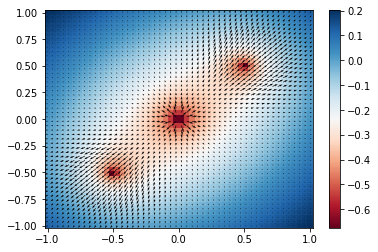

In [7]:
v_ex = prob2d_ex1.potential(x_plt_np[None,...])[0]
e_ex = prob2d_ex1.field(x_plt_np[None,...])[0]

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_ex.reshape(*x1_plt_msh_np.shape),
                  e_ex.reshape(*x1_plt_msh_np.shape, 2),
                  e_percentile_cap=90, dpi=72)

fig

### Defining the Volume Sampler

In [8]:
class BatchRNG:
    is_batch = True

    def __init__(self, shape, lib, device, dtype, 
                 unif_cache_cols=1_000_000, 
                 norm_cache_cols=5_000_000):
        assert lib in ('torch', 'numpy')
        
        self.lib = lib
        self.device = device

        self.shape = shape
        self.shape_prod = int(np.prod(self.shape))
        self.shape_len = len(self.shape)
        self.reset_shape_attrs(shape)
        
        if self.lib == 'torch':
            self.rngs = [torch.Generator(device=self.device) for _ in range(self.shape_prod)]
        else:
            self.rngs = [None for _ in range(self.shape_prod)]
        self.dtype = dtype

        self.unif_cache_cols = unif_cache_cols
        if self.lib == 'torch':
            self.unif_cache = torch.empty((self.shape_prod, self.unif_cache_cols),
                                          device=self.device, dtype=dtype)
        else:
            self.unif_cache = np.empty((self.shape_prod, self.unif_cache_cols), dtype=dtype)
        self.unif_cache_col_idx = self.unif_cache_cols  # So that it would get refilled immediately
        self.unif_cache_rng_states = None

        self.norm_cache_cols = norm_cache_cols
        if self.lib == 'torch':
            self.norm_cache = torch.empty((self.shape_prod, self.norm_cache_cols),
                                          device=self.device, dtype=dtype)
        else:
            self.norm_cache = np.empty((self.shape_prod, self.norm_cache_cols), dtype=dtype)
        self.norm_cache_col_idx = self.norm_cache_cols  # So that it would get refilled immediately
        self.norm_cache_rng_states = None
        
        self.np_qr = np.linalg.qr
        try:
            ver = tuple(int(x) for x in np.__version__.split('.'))
            np_majorver, np_minorver, np_patchver, *_ = ver
            if not((np_majorver >= 1) and (np_minorver >= 22)):
                def np_qr_fakebatch(a):
                    b = a.reshape(-1, a.shape[-2], a.shape[-1])
                    q, r = list(zip(*[np.linalg.qr(x) for x in b]))
                    qs = np.stack(q, axis=0)
                    rs = np.stack(r, axis=0)
                    qout = qs.reshape(*a.shape[:-2], qs.shape[-2], qs.shape[-1])
                    rout = rs.reshape(*a.shape[:-2], rs.shape[-2], rs.shape[-1])
                    return qout, rout
                self.np_qr = np_qr_fakebatch
        except Exception:
            pass

    def reset_shape_attrs(self, shape):
        self.shape = shape
        self.shape_prod = int(np.prod(self.shape))
        self.shape_len = len(self.shape)

    def seed(self, seed_arr):
        # Collecting the rng_states after seeding
        assert isinstance(seed_arr, np.ndarray)
        assert len(self.rngs) == seed_arr.size
        flat_seed_arr = seed_arr.copy().reshape(-1)
        if self.lib == 'torch':
            np_random = np.random.RandomState(seed=0)
            for seed, rng in zip(flat_seed_arr, self.rngs):
                np_random.seed(seed)
                balanced_32bit_seed = np_random.randint(0, 2**31-1, dtype=np.int32)
                rng.manual_seed(int(balanced_32bit_seed))
        else:
            self.rngs = [np.random.RandomState(seed=seed) for seed in flat_seed_arr]            

        if self.unif_cache_col_idx < self.unif_cache_cols:
            self.refill_unif_cache()
            # The cache has been used before, so in order to be able to
            # concat this sampler with the non-reseeded sampler, we should not
            # change the self.unif_cache_cols.

            # Note: We should not refill the uniform cache if the model
            # has not been initialized. This is done to keep the backward
            # compatibility and reproducibility properties with the old scripts.
            # Otherwise, the order of random samplings will change. Remember that
            # the old script first uses dirichlet and priors, and then refills
            # the unif/norm cache. In order to be similar, we should avoid
            # refilling the cache upon the first .seed() call
        if self.norm_cache_col_idx < self.norm_cache_cols:
            self.refill_norm_cache()

    def get_state(self):
        state_dict = dict(unif_cache_rng_states=self.unif_cache_rng_states,
                          norm_cache_rng_states=self.norm_cache_rng_states,
                          norm_cache_col_idx=self.norm_cache_col_idx,
                          unif_cache_col_idx=self.unif_cache_col_idx,
                          rng_states=self.get_rng_states(self.rngs))
        return state_dict

    def set_state(self, state_dict):
        unif_cache_rng_states = state_dict['unif_cache_rng_states']
        norm_cache_rng_states = state_dict['norm_cache_rng_states']
        norm_cache_col_idx = state_dict['norm_cache_col_idx']
        unif_cache_col_idx = state_dict['unif_cache_col_idx']
        rng_states = state_dict['rng_states']

        if unif_cache_rng_states is not None:
            self.set_rng_states(unif_cache_rng_states, self.rngs)
            self.refill_unif_cache()
            self.unif_cache_col_idx = unif_cache_col_idx
        else:
            self.unif_cache_col_idx = self.unif_cache_cols
            self.unif_cache_rng_states = None

        if norm_cache_rng_states is not None:
            self.set_rng_states(norm_cache_rng_states, self.rngs)
            self.refill_norm_cache()
            self.norm_cache_col_idx = norm_cache_col_idx
        else:
            self.norm_cache_col_idx = self.norm_cache_cols
            self.norm_cache_rng_states = None

        self.set_rng_states(rng_states, self.rngs)

    def get_rngs(self):
        return self.rngs

    def set_rngs(self, rngs, shape):
        assert isinstance(rngs, list)
        self.reset_shape_attrs(shape)
        self.rngs = rngs
        assert len(self.rngs) == self.shape_prod, f'{len(self.rngs)} != {self.shape_prod}'

    def get_rng_states(self, rngs):
        """
        getting state in ByteTensor
        """
        rng_states = []
        for i, rng in enumerate(rngs):
            rng_state = rng.get_state()
            if self.lib == 'torch':
                rng_state = rng_state.detach().clone()
            rng_states.append(rng_state)
        return rng_states

    def set_rng_states(self, rng_states, rngs):
        """
        rng_states should be ByteTensor (RNG state must be a torch.ByteTensor)
        """
        assert isinstance(rng_states, list), f'{type(rng_states)}, {rng_states}'
        for i, rng in enumerate(rngs):
            rs = rng_states[i]
            if self.lib == 'torch':
                rs = rs.cpu()
            rng.set_state(rs)

    def __call__(self, gen, sample_shape):
        assert self.lib == 'torch'
        sample_shape_rightmost = sample_shape[self.shape_len:]
        random_vars = []
        for i, rng in enumerate(self.rngs):
            rng_state = rng.get_state()
            rng_state = rng_state.detach().clone()
            torch.cuda.set_rng_state(rng_state, self.device)
            random_vars.append(gen.sample(sample_shape_rightmost))
            rng.set_state(torch.cuda.get_rng_state(self.device).detach().clone())
        rv = torch.stack(random_vars, dim=0).reshape(*sample_shape)
        return rv

    def dirichlet(self, gen_list, sample_shape):
        assert self.lib == 'torch'
        sample_shape_rightmost = sample_shape[self.shape_len:]
        random_vars = []
        for i, (gen_, rng) in enumerate(zip(gen_list, self.rngs)):
            rng_state = rng.get_state().detach().clone()
            torch.cuda.set_rng_state(rng_state, self.device)
            random_vars.append(gen_.sample(sample_shape_rightmost))
            rng.set_state(torch.cuda.get_rng_state(self.device).detach().clone())

        rv = torch.stack(random_vars, dim=0)
        rv = rv.reshape(*self.shape, *rv.shape[1:])
        return rv

    def refill_unif_cache(self):
        self.unif_cache_rng_states = self.get_rng_states(self.rngs)
        if self.lib == 'torch':
            for row, rng in enumerate(self.rngs):
                self.unif_cache[row].uniform_(generator=rng)
        else:
            for row, rng in enumerate(self.rngs):
                self.unif_cache[row] = rng.rand(self.unif_cache_cols)

    def refill_norm_cache(self):
        self.norm_cache_rng_states = self.get_rng_states(self.rngs)
        if self.lib == 'torch':
            for row, rng in enumerate(self.rngs):
                self.norm_cache[row].normal_(generator=rng)
        else:
            for row, rng in enumerate(self.rngs):
                self.norm_cache[row] = rng.randn(self.norm_cache_cols)

    def uniform(self, sample_shape):
        sample_shape_tuple = tuple(sample_shape)
        assert sample_shape_tuple[:self.shape_len] == self.shape

        sample_shape_rightmost = sample_shape[self.shape_len:]
        cols = np.prod(sample_shape_rightmost)
        if self.unif_cache_col_idx + cols >= self.unif_cache_cols:
            self.refill_unif_cache()
            self.unif_cache_col_idx = 0

        samples = self.unif_cache[:, self.unif_cache_col_idx: (self.unif_cache_col_idx + cols)]
        samples = samples.reshape(*sample_shape)
        self.unif_cache_col_idx += cols

        return samples

    def normal(self, sample_shape):
        sample_shape_tuple = tuple(sample_shape)
        cols = np.prod(sample_shape_tuple) // self.shape_prod
        assert cols * self.shape_prod == np.prod(sample_shape_tuple)
        if self.norm_cache_col_idx + cols >= self.norm_cache_cols:
            self.refill_norm_cache()
            self.norm_cache_col_idx = 0

        samples = self.norm_cache[:, self.norm_cache_col_idx: (self.norm_cache_col_idx + cols)]
        samples = samples.reshape(*sample_shape)
        self.norm_cache_col_idx += cols

        return samples
    
    def so_n(self, sample_shape):
        sample_shape_tuple = tuple(sample_shape)
        
        assert sample_shape_tuple[-2] == sample_shape_tuple[-1]
        n_bch, d = self.shape_prod, sample_shape_tuple[-1]
        sample_numel = np.prod(sample_shape_tuple)
        n_v = sample_numel // (self.shape_prod * d * d)
        assert sample_numel == (n_bch * n_v * d * d)
        qr_factorizer = torch.qr if self.lib == 'torch' else self.np_qr
        diagnalizer = torch.diagonal if self.lib == 'torch' else np.diagonal
        signer = torch.sign if self.lib == 'torch' else np.sign
        
        norms = self.normal((n_bch, n_v, d, d))
        assert norms.shape == (n_bch, n_v, d, d)
        q, r = qr_factorizer(norms)
        assert q.shape == (n_bch, n_v, d, d)
        assert r.shape == (n_bch, n_v, d, d)
        r_diag = diagnalizer(r, 0, -2, -1)
        assert r_diag.shape == (n_bch, n_v, d)
        r_diag_sign = signer(r_diag)
        assert r_diag_sign.shape == (n_bch, n_v, d)
        q_signed = q * r_diag_sign.reshape(n_bch, n_v, 1, d)
        assert q_signed.shape == (n_bch, n_v, d, d)
        so_n = q_signed.reshape(*sample_shape_tuple)
        assert so_n.shape == sample_shape_tuple

        return so_n

    @classmethod
    def Merge(cls, sampler1, sampler2):
        assert sampler1.shape_len == sampler2.shape_len == 1

        device = sampler1.device
        dtype = sampler1.dtype
        chain_size = (sampler1.shape[0]+sampler2.shape[0],)

        state_dict1, state_dict2 = sampler1.get_state(), sampler2.get_state()

        merged_state_dict = dict()
        for key in state_dict1:
            if key in ('unif_cache_rng_states', 'norm_cache_rng_states', 'rng_states'):
                # saba modified
                if (state_dict1[key] is None) and (state_dict2[key] is None):
                    merged_state_dict[key] = None
                elif (state_dict1[key] is None) or (state_dict2[key] is None):
                    raise ValueError(f"{key} with None occurance")
                else:
                    merged_state_dict[key] = state_dict1[key] + state_dict2[key]
            elif key in ('norm_cache_col_idx', 'unif_cache_col_idx'):
                assert state_dict1[key] == state_dict2[key]
                merged_state_dict[key] = state_dict1[key]
            else:
                raise ValueError(f'Unknown rule for {key}')

        sampler = cls(device, chain_size, dtype)
        sampler.set_state(merged_state_dict)
        return sampler

    @classmethod
    def Subset(cls, sampler, inds):
        assert sampler.shape_len == 1

        device = sampler.device
        dtype = sampler.dtype
        chain_size_sub = (len(inds),)

        state_dict = sampler.get_state()

        sub_state_dict = dict()
        for key in state_dict:
            if key in ('unif_cache_rng_states', 'norm_cache_rng_states',
                       'rng_states'):
                sub_state_dict[key] = [state_dict[key][ind] for ind in inds]
            elif key in ('norm_cache_col_idx', 'unif_cache_col_idx'):
                sub_state_dict[key] = state_dict[key]
            else:
                raise ValueError(f'Unknown rule for {key}')

        sampler = cls(device, chain_size_sub, dtype)
        sampler.set_state(sub_state_dict)
        return sampler

In [9]:
class BallSampler:
    def __init__(self, x_min, x_max, r_min, r_max, batch_rng):
        assert isinstance(x_min, np.ndarray)
        assert isinstance(x_max, np.ndarray)
        assert isinstance(r_min, np.ndarray)
        assert isinstance(r_max, np.ndarray)
        
        self.batch_rng = batch_rng
        self.lib = batch_rng.lib
        self.n_bch, self.d = x_min.shape
        self.x_min_np = x_min.reshape(self.n_bch, 1, self.d)
        self.x_max_np = x_max.reshape(self.n_bch, 1, self.d)
        self.r_min_np = r_min.reshape(self.n_bch, 1)
        self.r_max_np = r_max.reshape(self.n_bch, 1)
        self.x_size_np = (self.x_max_np - self.x_min_np)
        self.r_size_np = (self.r_max_np - self.r_min_np)
        
        if self.lib == 'torch':
            self.x_min_tch = torch.from_numpy(self.x_min_np).to(
                device=self.batch_rng.device, dtype=self.batch_rng.dtype)
            self.x_max_tch = torch.from_numpy(self.x_max_np).to(
                device=self.batch_rng.device, dtype=self.batch_rng.dtype)
            self.r_min_tch = torch.from_numpy(self.r_min_np).to(
                device=self.batch_rng.device, dtype=self.batch_rng.dtype)
            self.r_max_tch = torch.from_numpy(self.r_max_np).to(
                device=self.batch_rng.device, dtype=self.batch_rng.dtype)
            self.x_size_tch = torch.from_numpy(self.x_size_np).to(
                device=self.batch_rng.device, dtype=self.batch_rng.dtype)
            self.r_size_tch = torch.from_numpy(self.r_size_np).to(
                device=self.batch_rng.device, dtype=self.batch_rng.dtype)
            
        self.r_min = self.r_min_np if self.lib == 'numpy' else self.r_min_tch
        self.x_min = self.x_min_np if self.lib == 'numpy' else self.x_min_tch
        self.r_size = self.r_size_np if self.lib == 'numpy' else self.r_size_tch
        self.x_size = self.x_size_np if self.lib == 'numpy' else self.x_size_tch
    
    def __call__(self, n=1):
        radii = self.r_min + self.r_size * self.batch_rng.uniform((self.n_bch, n))
        centers = self.batch_rng.uniform((self.n_bch, n, self.d))
        centers = centers * self.x_size + self.x_min
        d = dict()
        d['type'] = 'balls'
        d['centers'] = centers
        d['radii'] = radii
        return d

### Visualizing the Sampler and Integrator

In [10]:
n_bch = 5
rng = BatchRNG(shape=(n_bch,), lib='torch', device=tch_device, dtype=tch_dtype, 
               unif_cache_cols=100, norm_cache_cols=500)
rng.seed(np.broadcast_to(12345+np.arange(n_bch), rng.shape))

prob2d_ex2 = DeltaProblem(weights=np.broadcast_to([1.0, 1.0, 1.0], (n_bch, 3)).copy(),
                          locations=np.broadcast_to([[ 0.0,  0.0],
                                                     [-0.5, -0.5],
                                                     [ 0.5,  0.5]], (n_bch, 3, 2)).copy())

volsampler_2d = BallSampler(x_min=np.broadcast_to([-1.0, -1.0], (n_bch, 2)).copy(), 
                            x_max=np.broadcast_to([ 1.0,  1.0], (n_bch, 2)).copy(), 
                            r_min=np.broadcast_to([0.1], (n_bch,)).copy(), 
                            r_max=np.broadcast_to([1.5], (n_bch,)).copy(),
                            batch_rng=rng)

vols = volsampler_2d(n=10)
integs = prob2d_ex2.integrate_volumes(vols)
for key, val in vols.items():
    if torch.is_tensor(val):
        vols[key] = val.detach().cpu().numpy()

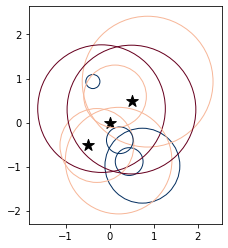

In [11]:
fig = plt.figure(dpi=72)
ax = plt.gca()

i = 0
max_integ = prob2d_ex2.weights[i][prob2d_ex2.weights[i] > 0].sum()
min_integ = prob2d_ex2.weights[i][prob2d_ex2.weights[i] < 0].sum()
cmap = mpl.cm.get_cmap('RdBu')
cnorm = mpl.colors.Normalize(vmin=min_integ, vmax=max_integ)

ax.scatter(prob2d_ex2.locations[i,:,0], prob2d_ex2.locations[i,:,1], marker='*', color='black', s=150)
for center, radius, integ in zip(vols['centers'][i], vols['radii'][i], integs[i]):
    circle = plt.Circle(center, radius, fill=False, 
                        color=cmap(1.0-cnorm(integ.item())))
    ax.add_patch(circle)
ax.set_aspect('equal', adjustable='box')
fig

### Sphere Sampling

In [12]:
class SphereSampler:
    def __init__(self, batch_rng):
        assert batch_rng.dtype == tch_dtype
        assert batch_rng.device == tch_device
        self.batch_rng = batch_rng
    
    def np_exlinspace(self, start, end, n):
        assert n >= 1
        a = np.linspace(start, end, n, endpoint=False) 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def tch_exlinspace(self, start, end, n):
        assert n >= 1
        a = torch.linspace(start, end, n+1, device=tch_device, dtype=tch_dtype)[:-1] 
        b = a + 0.5 * (end - a[-1])
        return b
    
    def __call__(self, volumes, n, do_detspacing=True):
        # volumes -> dictionary
        assert volumes['type'] == 'balls'
        centers = volumes['centers']
        radii = volumes['radii']
        n_bch, n_v, d = centers.shape
        use_np = not torch.is_tensor(centers)
        assert centers.shape == (n_bch, n_v, d)
        assert radii.shape == (n_bch, n_v)
        assert not(use_np) or (self.batch_rng.lib == 'numpy')
        assert use_np or (self.batch_rng.device == centers.device)
        assert use_np or (self.batch_rng.dtype == centers.dtype)
        assert self.batch_rng.shape == (n_bch,)
        exlinspace = self.np_exlinspace if use_np else self.tch_exlinspace
        meshgrid = np.meshgrid if use_np else torch.meshgrid
        sin = np.sin if use_np else torch.sin
        cos = np.cos if use_np else torch.cos
        matmul = np.matmul if use_np else torch.matmul
        
        if do_detspacing and (d == 2):
            theta = exlinspace(0.0, 2*np.pi, n)
            assert theta.shape == (n,)
            theta_2d = theta.reshape(n, 1)
            x_tilde_2d_list = [cos(theta_2d), sin(theta_2d)]
            if use_np:
                x_tilde_2d = np.concatenate(x_tilde_2d_list, axis=1)
            else:
                x_tilde_2d = torch.cat(x_tilde_2d_list, dim=1)
            assert x_tilde_2d.shape == (n ,d)
            x_tilde_4d = x_tilde_2d.reshape(1, 1, n, d)
            assert x_tilde_4d.shape == (1, 1, n ,d)
            x_tilde = x_tilde_4d.expand(n_bch, 1, n, d)
            assert x_tilde.shape == (n_bch, 1, n ,d)
        elif do_detspacing and (d == 3):
            n_sqrt = int(np.sqrt(n))
            assert n == n_sqrt * n_sqrt, 'Need n to be int-square for now!'
            theta_1d = exlinspace(0.0, 2*np.pi, n_sqrt)
            unit_unif = exlinspace(0.0, 1.0, n_sqrt)
            if use_np:
                phi_1d = np.arccos(1-2*unit_unif)
            else:
                phi_1d = torch.arccos(1-2*unit_unif)
            theta_msh, phi_msh = meshgrid(theta_1d, phi_1d)
            assert theta_msh.shape == (n_sqrt, n_sqrt)
            assert phi_msh.shape == (n_sqrt, n_sqrt)
            theta_2d, phi_2d = theta_msh.reshape(n, 1), phi_msh.reshape(n, 1)
            assert theta_2d.shape == (n, 1)
            assert phi_2d.shape == (n, 1)
            x_tilde_lst = [sin(phi_2d) * cos(theta), sin(phi_2d) * sin(theta), cos(phi_2d)]
            if use_np:
                x_tilde_2d = np.concatenate(x_tilde_lst, axis=1)
            else:
                x_tilde_2d = torch.cat(x_tilde_lst, dim=1)
            assert x_tilde_2d.shape == (n ,d)
            x_tilde_4d = x_tilde_2d.reshape(1, 1, n, d)
            assert x_tilde_4d.shape == (1, 1, n ,d)
            x_tilde = x_tilde_4d.expand(n_bch, 1, n, d)
            assert x_tilde.shape == (n_bch, 1, n ,d)
        elif (not do_detspacing) and (not use_np):
            x_tilde_unnorm = self.batch_rng.normal((n_bch, n_v, n, d))
            x_tilde_l2 = torch.sqrt(torch.square(x_tilde_unnorm).sum(dim=-1))
            x_tilde = x_tilde_unnorm / x_tilde_l2.reshape(n_bch, n_v, n, 1)
            assert x_tilde.shape == (n_bch, n_v, n ,d)
        else:
            raise RuntimeError('Not implemented yet!')
        
        if do_detspacing:
            rot_mats = self.batch_rng.so_n((n_bch, n_v, d, d))
            assert rot_mats.shape == (n_bch, n_v, d, d)
        
        if do_detspacing:
            x_tilde_rot = matmul(x_tilde, rot_mats)
        else:
            x_tilde_rot = x_tilde
        assert x_tilde_rot.shape == (n_bch, n_v, n, d)
        
        points = x_tilde_rot * radii.reshape(n_bch, n_v, 1, 1) + centers.reshape(n_bch, n_v, 1, d)
        assert points.shape == (n_bch, n_v, n, d)
        
        if use_np:
            x_tilde_bc = np.broadcast_to(x_tilde, (n_bch, n_v, n, d))
        else:
            x_tilde_bc = x_tilde.expand(n_bch, n_v, n, d)
            
        if do_detspacing: 
            rot_x_tilde = matmul(x_tilde_bc, rot_mats)
        else:
            rot_x_tilde = x_tilde_bc
        assert rot_x_tilde.shape == (n_bch, n_v, n, d)
        
        cst = (2*(np.pi**(d/2))) / gamma(d/2)
        csts = cst * (radii**(d-1))
        assert csts.shape == (n_bch, n_v)
        
        ret_dict = dict(points=points, normals=rot_x_tilde, areas=csts)
        return ret_dict

In [13]:
n_bch = 5
rng = BatchRNG(shape=(n_bch,), lib='torch', device=tch_device, dtype=tch_dtype, 
               unif_cache_cols=100, norm_cache_cols=500)
rng.seed(np.broadcast_to(12345+np.arange(n_bch), rng.shape))

prob2d_ex3 = DeltaProblem(weights=np.broadcast_to([1.0, 1.0, 1.0], (n_bch, 3)).copy(),
                          locations=np.broadcast_to([[ 0.0,  0.0],
                                                     [-0.5, -0.5],
                                                     [ 0.5,  0.5]], (n_bch, 3, 2)).copy())

volsampler_2d = BallSampler(x_min=np.broadcast_to([-1.0, -1.0], (n_bch, 2)).copy(), 
                            x_max=np.broadcast_to([ 1.0,  1.0], (n_bch, 2)).copy(), 
                            r_min=np.broadcast_to([0.1], (n_bch,)).copy(), 
                            r_max=np.broadcast_to([1.5], (n_bch,)).copy(),
                            batch_rng=rng)

sphsampler_2d = SphereSampler(batch_rng=rng)

vols = volsampler_2d(n=10)
sphsamps2d = sphsampler_2d(vols, 100, do_detspacing=True)
points = sphsamps2d['points']
surfacenorms = sphsamps2d['normals']
if torch.is_tensor(points):
    points = points.detach().cpu().numpy()
if torch.is_tensor(surfacenorms):
    surfacenorms = surfacenorms.detach().cpu().numpy()
points.shape, surfacenorms.shape

((5, 10, 100, 2), (5, 10, 100, 2))

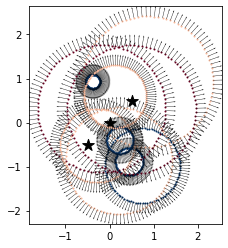

In [14]:
fig = plt.figure(dpi=72)
ax = plt.gca()

i = 0

max_integ = prob2d_ex3.weights[i][prob2d_ex3.weights[i] > 0].sum()
min_integ = prob2d_ex3.weights[i][prob2d_ex3.weights[i] < 0].sum()
cmap = mpl.cm.get_cmap('RdBu')
cnorm = mpl.colors.Normalize(vmin=min_integ, vmax=max_integ)

ax.scatter(prob2d_ex3.locations[i,:,0], prob2d_ex3.locations[i,:,1], 
           marker='*', color='black', s=150)
for pnts, srfnrms, center, radius, integ in zip(points[i], 
    surfacenorms[i], vols['centers'][i], vols['radii'][i], integs[i]):
    ax.scatter(pnts[:,0], pnts[:,1], marker='o', 
               color=cmap(1.0-cnorm(integ.item())), s=1)
    ax.quiver(pnts[:,0], pnts[:,1], srfnrms[:, 0], 
              srfnrms[:, 1], width=0.002)
ax.set_aspect('equal', adjustable='box')

fig

### Function Approximation

In [15]:
class bffnn(nn.Module):
    """batched FF network for approximating functions"""
    def __init__(self, inp_width, nn_width, num_hidden, shape, batch_rng):
        super().__init__()
        self.layer_first = nn.ParameterList(self.make_linear(shape, inp_width, nn_width, batch_rng))
        layers_w, layers_b = [], []
        for _ in range(num_hidden):
            w, b = self.make_linear(shape, nn_width, nn_width, batch_rng)
            layers_w.append(w)
            layers_b.append(b)
        self.layer_hidden_w = nn.ParameterList(layers_w)
        self.layer_hidden_b = nn.ParameterList(layers_b)
        self.layer_last = nn.ParameterList(self.make_linear(shape, nn_width, 1, batch_rng))
        self.inp_width = inp_width
    
        self.shape = shape
        self.ndim = len(shape)
        self.size = int(np.prod(shape))
        
        
    def forward(self, x):
        activation = nn.SiLU()
        assert x.shape[:self.ndim] == self.shape
        assert x.shape[-1] == self.inp_width
        bdims = self.shape
        hidden_w, hidden_b = self.layer_hidden_w, self.layer_hidden_b
        inp_width = self.inp_width
        x_middims = x.shape[self.ndim:-1]
        x_pts = int(np.prod(x_middims))
        # x.shape --> ( n_bch, n_spheres,  n_points,        d)
        
        u = x.reshape(*bdims,                x_pts, inp_width)
        # u.shape --> (n_bch, n_spheres * n_points,         d)
        
        w, b = self.layer_first
        # w.shape --> (n_bch,                    d,   nn_width)
        # b.shape --> (n_bch,                    1,   nn_width)
        
        u = activation(torch.matmul(u, w) + b)
        # u.shape --> (n_bch, n_spheres * n_points,   nn_width)
        
        for _, (w, b) in enumerate(zip(hidden_w, hidden_b)):
            u = activation(torch.matmul(u, w) + b)
        # u.shape --> (n_bch, n_spheres * n_points,   nn_width)
        
        w, b = self.layer_last        
        u = torch.matmul(u, w) + b
        # u.shape --> (n_bch, n_spheres * n_points,          1)
        
        u = u.reshape(*x.shape[:-1], 1)
        # u.shape --> (n_bch, n_spheres,  n_points,          1)
        return u
    
    def make_linear(self, shape, inp_width, out_width, batch_rng):
        k = 1./ np.sqrt(inp_width).item()
        with torch.no_grad():
            w_unit = batch_rng.uniform((*shape, inp_width, out_width))
            b_unit = batch_rng.uniform((*shape,         1, out_width))
            w_tensor = w_unit * (2 * k) - k
            b_tensor = b_unit * (2 * k) - k
        w = torch.nn.Parameter(w_tensor)
        b = torch.nn.Parameter(b_tensor)
        return w, b
    
def split_eval(model, x, n_eval):
    x_rows, x_cols = tuple(x.shape)
    v_pred_np_list = []
    e_pred_np_list = []
    for i in range(int(np.ceil(x_rows/n_eval))):
        x_i = x[(i*n_eval):((i+1)*n_eval), :]
        nr = x_i.shape[0]
        x_ii = x_i.reshape(*([1]*model.ndim),nr,x_cols).expand(*model.shape,nr,x_cols)
        x_iii = nn.Parameter(x_ii)
        v_pred_i = model(x_iii)
        e_pred_i, = torch.autograd.grad(v_pred_i.sum(), [x_iii], grad_outputs=None, retain_graph=False,
                                        create_graph=False, only_inputs=True, allow_unused=False)
        v_pred_np_i = v_pred_i.squeeze().detach().cpu().numpy()
        e_pred_np_i = e_pred_i.squeeze().detach().cpu().numpy()
        v_pred_np_list.append(v_pred_np_i)
        e_pred_np_list.append(e_pred_np_i)
    v_pred_np = np.concatenate(v_pred_np_list, axis=1)
    e_pred_np = np.concatenate(e_pred_np_list, axis=1)  
    return v_pred_np, e_pred_np

### Defining the Problem

In [16]:
# Set the problem
d = 2
n_spheres = 400
n_points = 2
trg_weight = 0.99
n_epochs = 200_000
do_detspacing = False
n_seeds = 25
lr = 0.001
tau = 0.999

n_points_mdl = 1
n_points_trg = n_points - n_points_mdl

rng_seeds = 12345 + np.arange(n_seeds) * 1000
rng = BatchRNG(shape=(n_seeds,), lib='torch', device=tch_device, dtype=tch_dtype, 
               unif_cache_cols=1_000_000, norm_cache_cols=5_000_000)
rng.seed(np.broadcast_to(rng_seeds, rng.shape))

problem = DeltaProblem(weights=np.broadcast_to([1.0, 1.0, 1.0], (n_seeds, 3)).copy(),
                       locations=np.broadcast_to([[ 0.0] * d, [-0.5] * d, [ 0.5] * d], 
                                                 (n_seeds, 3, d)).copy())

volsampler = BallSampler(x_min=np.broadcast_to([-1.0] * d, (n_seeds, d)).copy(), 
                            x_max=np.broadcast_to([ 1.0] * d, (n_seeds, d)).copy(), 
                            r_min=np.broadcast_to([0.1], (n_seeds,)).copy(), 
                            r_max=np.broadcast_to([1.5], (n_seeds,)).copy(),
                            batch_rng=rng)

sphsampler = SphereSampler(batch_rng=rng)

### Training Loop

In [17]:
if 'writer' in locals():
    writer.close()

In [18]:
rootlogdir = 'temp'
! mkdir -p {rootlogdir}
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
storage_dir = f'{rootlogdir}/01_highvar_bstrap_{timestamp}'

In [19]:
if 'writer' in locals():
    writer.close()
writer = tensorboardX.SummaryWriter(storage_dir)

# Initializing the model
nn_width, nn_hidden = 64, 2
model = bffnn(d, nn_width, nn_hidden, (n_seeds,), rng)
model_target = bffnn(d, nn_width, nn_hidden, (n_seeds,), rng)
model_target.load_state_dict(model.state_dict())

# Set the optimizer
opt = torch.optim.Adam(model.parameters(), lr)

stat_history = defaultdict(list)
model_history = odict()
model_trg_history = odict()
hp_dict = dict(lr=lr, n_spheres=n_spheres, n_points=n_points, 
               dim=d, nn_width=nn_width, nn_hidden=nn_hidden,
               do_detspacing=do_detspacing, tau=tau, 
               n_points_mdl=n_points_mdl, n_points_trg=n_points_trg,
               trg_weight=trg_weight)

for epoch in range(n_epochs):
    opt.zero_grad()
    
    # Sampling the volumes
    volsamps = volsampler(n=n_spheres)
    
    # Sampling the points from the spheres
    sphsamps = sphsampler(volsamps, n_points, do_detspacing=do_detspacing)
    points = nn.Parameter(sphsamps['points'])
    surfacenorms = sphsamps['normals']
    areas = sphsamps['areas']
    assert points.shape == (n_seeds, n_spheres, n_points, d)
    assert surfacenorms.shape == (n_seeds, n_spheres, n_points, d)
    assert areas.shape == (n_seeds, n_spheres,)
    
    points_mdl = points[:, :, :n_points_mdl, :]
    assert points_mdl.shape == (n_seeds, n_spheres, n_points_mdl, d)
    points_trg = points[:, :, n_points_mdl:, :]
    assert points_trg.shape == (n_seeds, n_spheres, n_points_trg, d)
    
    surfacenorms_mdl = surfacenorms[:, :, :n_points_mdl, :]
    assert surfacenorms_mdl.shape == (n_seeds, n_spheres, n_points_mdl, d)
    surfacenorms_trg = surfacenorms[:, :, n_points_mdl:, :]
    assert surfacenorms_trg.shape == (n_seeds, n_spheres, n_points_trg, d)
    
    # Making surface integral predictions using the reference model
    u_mdl = model(points_mdl)
    assert u_mdl.shape == (n_seeds, n_spheres, n_points_mdl, 1)
    nabla_x_u_mdl, = torch.autograd.grad(u_mdl.sum(), [points_mdl], grad_outputs=None, retain_graph=True,
                                         create_graph=True, only_inputs=True, allow_unused=False)
    assert nabla_x_u_mdl.shape == (n_seeds, n_spheres, n_points_mdl, d)
    normprods_mdl = (nabla_x_u_mdl * surfacenorms_mdl).sum(dim=-1)
    assert normprods_mdl.shape == (n_seeds, n_spheres, n_points_mdl)
    mean_normprods_mdl = normprods_mdl.mean(dim=-1)
    assert mean_normprods_mdl.shape == (n_seeds, n_spheres)
    
    # Making surface integral predictions using the target model
    u_trg = model_target(points_trg)
    assert u_trg.shape == (n_seeds, n_spheres, n_points_trg, 1)
    nabla_x_u_trg, = torch.autograd.grad(u_trg.sum(), [points_trg], grad_outputs=None, retain_graph=True,
                                         create_graph=False, only_inputs=True, allow_unused=False)
    assert nabla_x_u_trg.shape == (n_seeds, n_spheres, n_points_trg, d)
    with torch.no_grad():
        normprods_trg = (nabla_x_u_trg * surfacenorms_trg).sum(dim=-1)
        assert normprods_trg.shape == (n_seeds, n_spheres, n_points_trg)
        mean_normprods_trg = normprods_trg.mean(dim=-1)
        assert mean_normprods_trg.shape == (n_seeds, n_spheres)
    
    # Linearly combining the reference and target predictions
    mean_normprods = trg_weight * mean_normprods_trg.detach() + (1.0 - trg_weight) * mean_normprods_mdl
    assert mean_normprods.shape == (n_seeds, n_spheres)
    
    # Considering the surface areas
    pred_surfintegs = mean_normprods * areas
    assert pred_surfintegs.shape == (n_seeds, n_spheres)
    
    # Getting the reference volume integrals
    ref_volintegs = problem.integrate_volumes(volsamps)
    assert ref_volintegs.shape == (n_seeds, n_spheres)
    
    # Computing the loss
    loss_main = torch.square(pred_surfintegs - ref_volintegs).mean(-1)
    assert loss_main.shape == (n_seeds,)

    with torch.no_grad():
        u_mdl_prime = model_target(points_mdl)
    loss_trgreg = torch.square(u_mdl - u_mdl_prime).mean([-3, -2, -1])
    assert loss_trgreg.shape == (n_seeds,)

    loss = loss_main + loss_trgreg
    assert loss.shape == (n_seeds,)

    loss_sum = loss.sum()
    
    loss_sum.backward()
    opt.step()
    
    # Updating the target network
    model_sd = model.state_dict()
    model_trg_sd = model_target.state_dict()
    newtrg_sd = dict()
    with torch.no_grad():
        for key, param in model_sd.items():
            param_trg = model_trg_sd[key]
            newtrg_sd[key] = tau * param_trg + (1-tau) * param
    model_target.load_state_dict(newtrg_sd)
    
    # Computing the loss moving averages
    ema_gamma, ema_gamma_sq = 0.999, 0.998
    with torch.no_grad():
        loss_ema = loss if epoch == 0 else ema_gamma * loss_ema + (1-ema_gamma) * loss
        loss_ema_sq = (loss**2) if epoch == 0 else ema_gamma_sq * loss_ema_sq + (1-ema_gamma_sq) * (loss**2)
        loss_popvar = (loss_ema_sq - (loss_ema**2)).detach().cpu().numpy()
        loss_popvar[loss_popvar < 0] = 0
        loss_ema_std = np.sqrt(loss_popvar) * np.sqrt((1-ema_gamma)/(1+ema_gamma))

        normprods = torch.cat([normprods_mdl, normprods_trg], dim=-1)
        npvm = (normprods.var(dim=-1)*areas.square()).mean(-1)
        npvm_ema = npvm if epoch == 0 else ema_gamma * npvm_ema + (1-ema_gamma) * npvm
        npvm_ema_sq = (npvm**2) if epoch == 0 else ema_gamma_sq * npvm_ema_sq + (1-ema_gamma_sq) * (npvm**2)
        npvm_popvar = (npvm_ema_sq - (npvm_ema**2)).detach().cpu().numpy()
        npvm_popvar[npvm_popvar < 0] = 0
        npvm_ema_std = np.sqrt(npvm_popvar) * np.sqrt((1-ema_gamma)/(1+ema_gamma))
        
        loss_mean = loss.mean()
        npvm_mean = npvm.mean()
        loss_trgreg_mean = loss_trgreg.mean()
    
    writer.add_scalar('loss/loss', loss_mean, epoch)
    writer.add_scalar('loss/npvm', npvm_mean, epoch)
    writer.add_scalar('loss/trgreg', loss_trgreg_mean, epoch)
    stat_history['epoch'] += [epoch] * n_seeds
    stat_history['rng_seed'] += rng_seeds.tolist()
    stat_history['loss'] += loss.tolist()
    stat_history['npvm'] += npvm.tolist()
    
    if epoch % 1000 == 0:
        with torch.no_grad():
            loss_ema_mean = loss_ema.mean()
            loss_ema_std_mean = np.sqrt((loss_ema_std**2).sum()) / n_seeds
            npvm_ema_mean = npvm_ema.mean()
            npvm_ema_std_mean = np.sqrt((npvm_ema_std**2).sum()) / n_seeds
        print_str  = f'epoch {epoch}, EMA loss = {loss_ema_mean:.4f} +/- {2*loss_ema_std_mean:.4f}'
        print_str += f', EMA Field-Norm Product Variance = {npvm_ema_mean:.4f} +/- {2*npvm_ema_std_mean:.4f}'
        print(print_str)
    if epoch % 1000 == 0:
        v_pred_np, e_pred_np = split_eval(model, x_plt, n_spheres*n_points_mdl)
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_np.mean(0).reshape(*x1_plt_msh_np.shape),
                          e_pred_np.mean(0).reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/reference', fig, epoch)
        
        v_pred_trg_np, e_pred_trg_np = split_eval(model_target, x_plt, n_spheres*n_points_trg)
        fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                          v_pred_trg_np.mean(0).reshape(*x1_plt_msh_np.shape),
                          e_pred_trg_np.mean(0).reshape(*x1_plt_msh_np.shape, 2), 
                          e_percentile_cap=90, dpi=100)
        writer.add_figure('visualization/target', fig, epoch)
        
        writer.flush()
        model_history[epoch] = deepcopy({k: v.cpu() for k, v in model.state_dict().items()})
        model_trg_history[epoch] = deepcopy({k: v.cpu() for k, v in model_target.state_dict().items()})

epoch 0, EMA loss = 2.9411 +/- 0.0000, EMA Field-Norm Product Variance = 0.0052 +/- 0.0000
epoch 1000, EMA loss = 2.2623 +/- 0.0000, EMA Field-Norm Product Variance = 1.1050 +/- 0.0108
epoch 2000, EMA loss = 1.5416 +/- 0.0000, EMA Field-Norm Product Variance = 0.7489 +/- 0.0018
epoch 3000, EMA loss = 1.0855 +/- 0.0000, EMA Field-Norm Product Variance = 0.5203 +/- 0.0000
epoch 4000, EMA loss = 0.7963 +/- 0.0000, EMA Field-Norm Product Variance = 0.4057 +/- 0.0000
epoch 5000, EMA loss = 0.6295 +/- 0.0000, EMA Field-Norm Product Variance = 0.3574 +/- 0.0000
epoch 6000, EMA loss = 0.5417 +/- 0.0000, EMA Field-Norm Product Variance = 0.3637 +/- 0.0005
epoch 7000, EMA loss = 0.5194 +/- 0.0000, EMA Field-Norm Product Variance = 0.4009 +/- 0.0012
epoch 8000, EMA loss = 0.5381 +/- 0.0010, EMA Field-Norm Product Variance = 0.4539 +/- 0.0015
epoch 9000, EMA loss = 0.5758 +/- 0.0014, EMA Field-Norm Product Variance = 0.5100 +/- 0.0016
epoch 10000, EMA loss = 0.6187 +/- 0.0016, EMA Field-Norm Produ

epoch 87000, EMA loss = 1.2533 +/- 0.0028, EMA Field-Norm Product Variance = 1.3052 +/- 0.0029
epoch 88000, EMA loss = 1.2519 +/- 0.0026, EMA Field-Norm Product Variance = 1.2873 +/- 0.0021
epoch 89000, EMA loss = 1.2401 +/- 0.0023, EMA Field-Norm Product Variance = 1.2803 +/- 0.0023
epoch 90000, EMA loss = 1.2429 +/- 0.0026, EMA Field-Norm Product Variance = 1.2870 +/- 0.0026
epoch 91000, EMA loss = 1.2431 +/- 0.0026, EMA Field-Norm Product Variance = 1.2859 +/- 0.0025
epoch 92000, EMA loss = 1.2536 +/- 0.0028, EMA Field-Norm Product Variance = 1.3034 +/- 0.0028
epoch 93000, EMA loss = 1.2586 +/- 0.0027, EMA Field-Norm Product Variance = 1.3039 +/- 0.0025
epoch 94000, EMA loss = 1.2638 +/- 0.0028, EMA Field-Norm Product Variance = 1.3132 +/- 0.0027
epoch 95000, EMA loss = 1.2688 +/- 0.0028, EMA Field-Norm Product Variance = 1.3156 +/- 0.0026
epoch 96000, EMA loss = 1.2679 +/- 0.0026, EMA Field-Norm Product Variance = 1.3087 +/- 0.0024
epoch 97000, EMA loss = 1.2694 +/- 0.0027, EMA Fie

epoch 173000, EMA loss = 1.3554 +/- 0.0033, EMA Field-Norm Product Variance = 1.4096 +/- 0.0031
epoch 174000, EMA loss = 1.3644 +/- 0.0034, EMA Field-Norm Product Variance = 1.4187 +/- 0.0032
epoch 175000, EMA loss = 1.3688 +/- 0.0036, EMA Field-Norm Product Variance = 1.4306 +/- 0.0036
epoch 176000, EMA loss = 1.3799 +/- 0.0037, EMA Field-Norm Product Variance = 1.4415 +/- 0.0033
epoch 177000, EMA loss = 1.3800 +/- 0.0035, EMA Field-Norm Product Variance = 1.4459 +/- 0.0033
epoch 178000, EMA loss = 1.3809 +/- 0.0035, EMA Field-Norm Product Variance = 1.4285 +/- 0.0028
epoch 179000, EMA loss = 1.3622 +/- 0.0029, EMA Field-Norm Product Variance = 1.4126 +/- 0.0028
epoch 180000, EMA loss = 1.3585 +/- 0.0032, EMA Field-Norm Product Variance = 1.4139 +/- 0.0029
epoch 181000, EMA loss = 1.3595 +/- 0.0034, EMA Field-Norm Product Variance = 1.4235 +/- 0.0034
epoch 182000, EMA loss = 1.3755 +/- 0.0036, EMA Field-Norm Product Variance = 1.4300 +/- 0.0031
epoch 183000, EMA loss = 1.3695 +/- 0.00

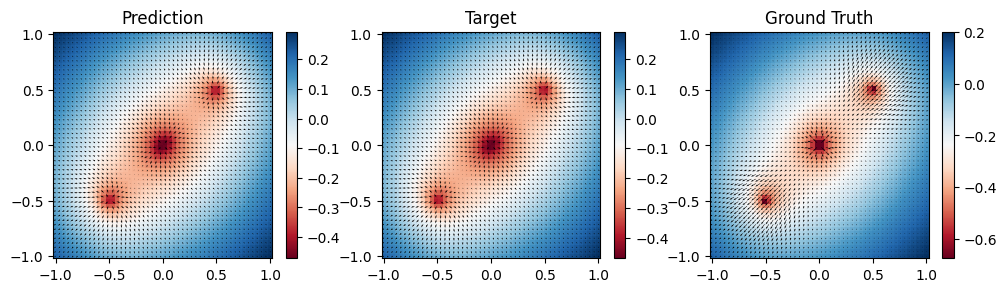

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=100)

v_pred_np, e_pred_np = split_eval(model, x_plt, n_spheres*n_points_mdl)
v_pred_trg_np, e_pred_trg_np = split_eval(model_target, x_plt, n_spheres*n_points_trg)

x_plt_np_bcast = np.broadcast_to(x_plt_np.reshape(1, *x_plt_np.shape), (n_seeds, *x_plt_np.shape))
v_true = problem.potential(x_plt_np_bcast)
e_true = problem.field(x_plt_np_bcast)

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_np.mean(0).reshape(*x1_plt_msh_np.shape),
                  e_pred_np.mean(0).reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[0]))
ax.set_title('Prediction')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_pred_trg_np.mean(0).reshape(*x1_plt_msh_np.shape),
                  e_pred_trg_np.mean(0).reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[1]))
ax.set_title('Target')

fig, ax = do_plot(x1_plt_msh_np, x2_plt_msh_np, 
                  v_true[0].reshape(*x1_plt_msh_np.shape),
                  e_true[0].reshape(*x1_plt_msh_np.shape, 2), 
                  e_percentile_cap=90, dpi=72, fig_ax=(fig, axes[2]))
ax.set_title('Ground Truth')
fig

In [21]:
torch.save(model_history, f'{storage_dir}/checkpoints.pt')
torch.save(model_trg_history, f'{storage_dir}/checkpoints_trg.pt')
df = pd.DataFrame(stat_history)
for key, val in hp_dict.items():
    df[key] = val
df.to_csv(f'{storage_dir}/progress.csv', index=False)
fig.savefig(f'{storage_dir}/finalpred.pdf', dpi=144, bbox_inches="tight")